# Plot wing loading
## AOA=12 degrees

In [1]:
%%capture
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
sys.path.insert(1, './utilities')
import utilities
import plot_wing
import definitions as defs

In [2]:
            # Label,              Filenames                              dictionary
runlist = [['SST',                './tipvortex1-aoa-12/rundir',          {'color':'r', 'ls':'--', 'ms':''}],
           ['SST-IDDES',          './sst-iddes-12/rundir',               {'color':'b', 'ls':'-', 'ms':''}],
           ['SST-IDDES localupw', './sst-iddes-12.localupwind/rundir',   {'color':'g', 'ls':'', 'ms':'+'}],
          ]

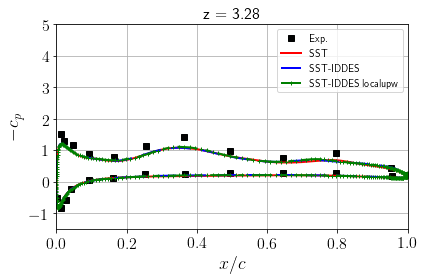

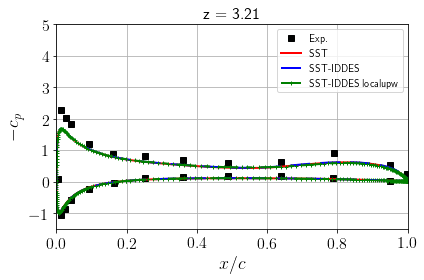

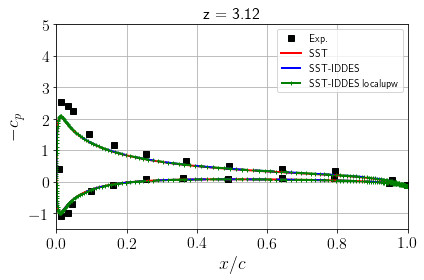

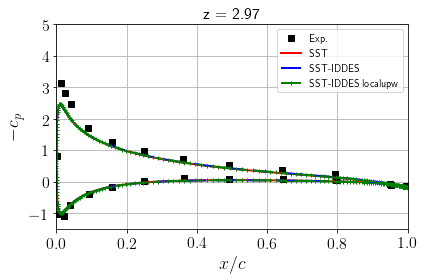

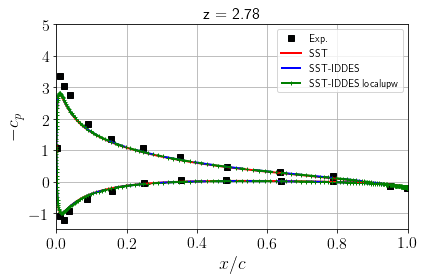

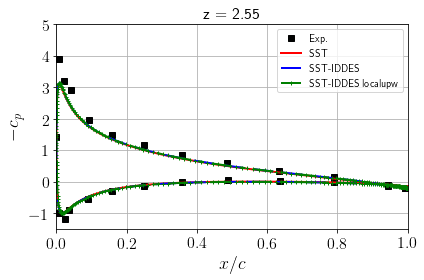

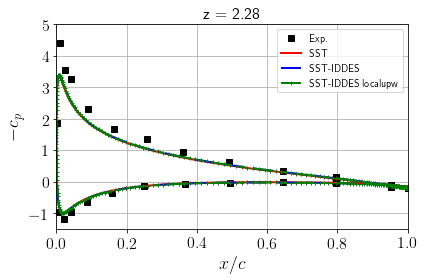

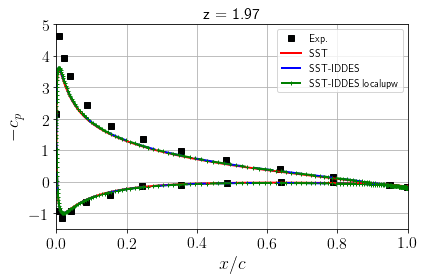

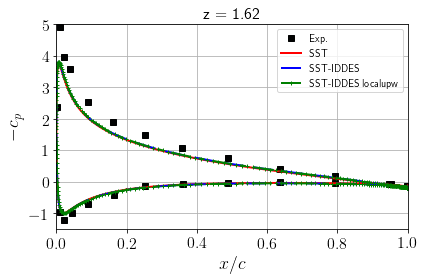

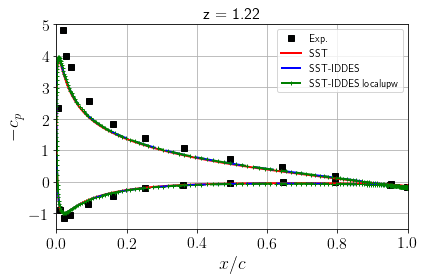

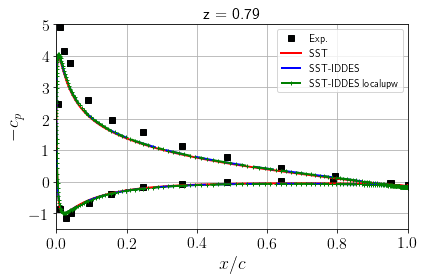

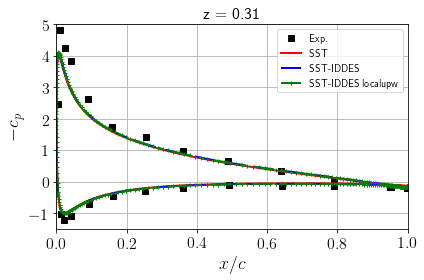

In [3]:
# Loop on folders
for i, run in enumerate(runlist):
    folder  =run[1]
    rundict = run[2]
    # Setup
    fdir = os.path.abspath(folder)
    yname = os.path.join(fdir, "mcalister.yaml")
    fname = "avg_slice.csv"
    dim = defs.get_dimension(yname)
    half_wing_length = defs.get_half_wing_length()

    # simulation setup parameters
    u0, v0, w0, umag0, rho0, mu, flow_angle = utilities.parse_ic(yname)
    mname = utilities.get_meshname(yname)
    aoa = defs.get_aoa(mname)
    chord = 1

    # experimental values
    edir = os.path.abspath(os.path.join("utilities/exp_data", f"aoa-{aoa}"))
    zslices = utilities.get_wing_slices(dim)
    zslices["zslicen"] = zslices.zslice / half_wing_length
    
    # data from other CFD simulations (SA model)
    sadir = os.path.abspath(os.path.join("sitaraman_data", f"aoa-{aoa}"))

    # Read in data
    df = pd.read_csv(os.path.join(fdir, "wing_slices", fname), delimiter=",")
    renames = utilities.get_renames()
    df.columns = [renames[col] for col in df.columns]

    # Project coordinates on to chord axis
    chord_angle = np.radians(aoa) - flow_angle
    crdvec = np.array([np.cos(chord_angle), -np.sin(chord_angle)])
    rotcen = 0.25
    df["xovc"] = (
                np.dot(np.asarray([df.x - rotcen, df.y]).T, crdvec) / chord + rotcen
    )

    # Calculate the negative of the surface pressure coefficient
    df["cp"] = -df.p / (0.5 * rho0 * umag0 ** 2)
            
    # Plot cp in each slice
    for k, (index, row) in enumerate(zslices.iterrows()):
        subdf = df[np.fabs(df.z - row.zslice) < 1e-5]
        # plot
        plt.figure(k)
        # Load corresponding exp data
        if i == 0:
            try:
                ename = glob.glob(os.path.join(edir, f"cp_*_{row.zslicen:.3f}.txt"))[0]
                exp_df = pd.read_csv(ename, header=0, names=["x", "cp"])
                plt.plot(
                        exp_df.x,
                        exp_df.cp,
                        ls="",
                        color=plot_wing.cmap[-1],
                        marker=plot_wing.markertype[0],
                        ms=6,
                        mec=plot_wing.cmap[-1],
                        mfc=plot_wing.cmap[-1],
                        label="Exp.",
                )
            except IndexError:
                print('Cannot load exp-data')
                pass
            
        # Plot the CFD data
        # Sort for a pretty plot
        x, y, cp = plot_wing.sort_by_angle(subdf.xovc.values, subdf.y.values, subdf.cp.values)

        p = plt.plot(x, cp, linestyle=rundict['ls'], lw=2, color=rundict['color'], marker=rundict['ms'], markersize=4, label=run[0])
        p[0].set_dashes(plot_wing.dashseq[i])
        
# Format the plot
for k, (index, row) in enumerate(zslices.iterrows()):
    plt.figure(k)
    ax = plt.gca()
    plt.xlabel(r"$x/c$", fontsize=18, fontweight="bold")
    plt.ylabel(r"$-c_p$", fontsize=18, fontweight="bold")
    plt.setp(ax.get_xmajorticklabels(), fontsize=16, fontweight="bold")
    plt.setp(ax.get_ymajorticklabels(), fontsize=16, fontweight="bold")
    plt.xlim([0, chord])
    plt.ylim([-1.5, 5.0])
    plt.title('z = %.2f'%row.zslice, fontsize=16)
    plt.grid()
    plt.legend()
    plt.tight_layout()